# Model Training for Car Evaluation, Target: Buying Price

- Model created - Ensemble Model with the following models:
    - Random Forest model
    - Logistic regression model
    - Decision tree model
    - Naive Bayes model

In [1]:
# Libraries used in training

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import pickle


### Reading data from car.data
- Column is as defined in car.c45-names

In [2]:
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv("./dataset/car.data", header=None, names=column_names)
df.reset_index(inplace=True, drop=True)

### Cleaning and dummify variables for training
- Row with missing value is dropped
- All categorical are dummify
- label ('buying') is encoded

In [3]:
# Drop rows with null
df.dropna(inplace=True)

# Dummify data
df = pd.get_dummies(df, columns=['maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

# Encoding label
le = LabelEncoder()
le.fit(df['buying'])
df['buying'] = le.transform(df['buying'])

### Spliting data
- Data is split into train and test with 80/20 rule

In [4]:
X = df.drop('buying', axis=1)
y = df['buying']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20230204)

### Training of models
- The following models, Random Forest model, Logistic regression model,Decision tree model and Naive Bayes model will be trained with Hyperparameter tuning for best result


In [5]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'criterion': ['gini', 'entropy']
}

# Random Forest model
rf = RandomForestClassifier()

# Setup grid search
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy')

# Train model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Params: ", best_params)

# Train a new Random Forest model with best hyperparameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)

# Check model accuracy against test
#y_pred = rf_best.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Random Forest Model Accuracy: ", accuracy)

Best Params:  {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}


RandomForestClassifier(max_depth=3)

In [6]:
# Hyperparameter grid
param_grid = {'C': [0.1, 1, 10, 100], 
              'penalty': ['l1', 'l2']}

# Logistic regression model
log_reg = LogisticRegression()

# Setup grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Train model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Params: ", best_params)

# Train a new Logistic regression model with best hyperparameters
log_reg_best = LogisticRegression(**best_params)
log_reg_best.fit(X_train, y_train)

# Check model accuracy against test
#y_pred = log_reg_best.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Logistic Regression Model Accuracy: ", accuracy)

Best Params:  {'C': 1, 'penalty': 'l2'}


LogisticRegression(C=1)

In [7]:
# Hyperparameter grid
param_grid = {'max_depth': [3, 5, 7, 9], 
              'min_samples_split': [2, 4, 6, 8]}

# Decision tree model
dt = DecisionTreeClassifier()

# Setup grid search
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

# Train model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Params: ", best_params)

# Train a new Decision tree model with best hyperparameters
dt_best = DecisionTreeClassifier(**best_params)
dt_best.fit(X_train, y_train)

# Check model accuracy against test
#y_pred = dt_best.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Decision tree Model Accuracy: ", accuracy)

Best Params:  {'max_depth': 3, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=3)

In [8]:
# Naive Bayes model
nb = GaussianNB()

# Train model
nb.fit(X_train, y_train)

# Check model accuracy against test
#y_pred = nb.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Naive Bayes model Accuracy: ", accuracy)

GaussianNB()

### Ensemble model
- Using soft voting to get best prediction of highest probabilities

In [9]:
# Ensemble model using above models with voting classifier
ensemble_model = VotingClassifier(estimators=[('rf', rf_best), ('lr', log_reg_best), ('dt', dt_best), ('nb', nb)], voting='soft')
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(max_depth=3)),
                             ('lr', LogisticRegression(C=1)),
                             ('dt', DecisionTreeClassifier(max_depth=3)),
                             ('nb', GaussianNB())],
                 voting='soft')

### Evaluate Model Performance
- The ensemble model could only produce a low accuracy of around <b>30%</b>

In [10]:
# Check model accuracy against test
y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Accuracy: ", accuracy)

Ensemble Model Accuracy:  0.3468208092485549


### Saving model for production use
- Item saved:
    - Model
    - Dummies columns name
    - Label encoder is saved
- These are required to transform test data into same format as training data

In [11]:
# Save the model to a file
filename = str(accuracy)[2:7]
with open(f'./trained_models/buying_price_model_{filename}.pkl', 'wb') as file:
    pickle.dump(ensemble_model, file)

# Save the dummies column name to a file
with open(f'./trained_models/buying_price_model_{filename}_dummies_columns.pkl', 'wb') as file:
    pickle.dump(X.columns, file)
    
# Save the label encoder to a file
with open(f'./trained_models/buying_price_model_{filename}_label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)    

### Explaining Poor Model Performance
- The prediction label, buying, has poor correlation with the other attributes. 
- Hence, it is difficult for any model to perform well with accurate prediction
- The plot below show there is near 0 correlation with other attributes

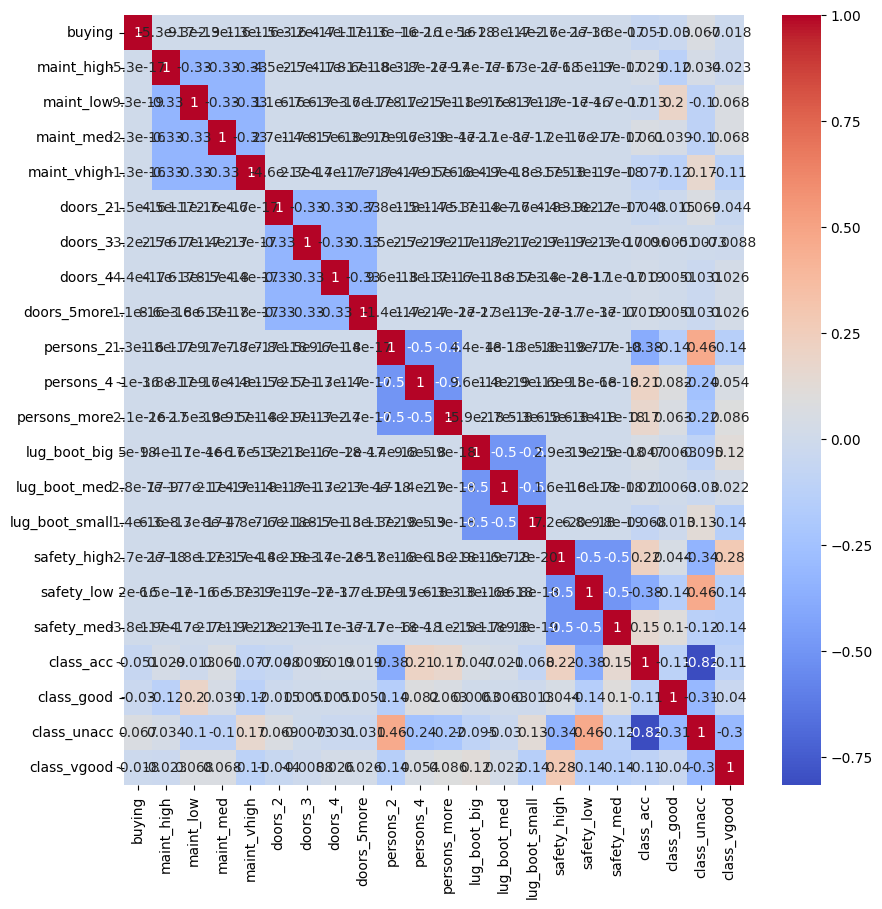

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

# Show the plot
plt.show()